<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/Comparing_Dimensionality_Reduction_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install packages

In [ ]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.8 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from umap import UMAP
from umap.plot import points
import umap

from tensorflow.keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,\
                            confusion_matrix,\
                            classification_report,\
                            silhouette_score

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

# Config

In [ ]:
image_size = 28
sample_size = 20000

In [ ]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = get_mnist_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
components = [100, 200, 300, 400, 500] + list(range(501, 600, 5)) + [600, 784]
flat_X_train = X_train[:sample_size].reshape(len(X_train[:sample_size]), -1)

# Preprocessing

(60000, 28, 28)


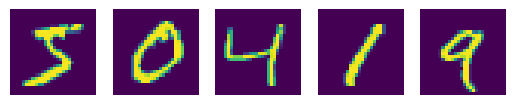

In [ ]:
print(X_train.shape)
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

## Sobel Edge Detection

# Dimensionality Reduction

In [ ]:
eval_metrics = dict()

In [ ]:
X_train.shape

(60000, 28, 28)

## Helpers

In [ ]:
def eval_dim_reduc(model, flat_X, y, label:str):
  reconstruction_mse, silhouette = None, None

  # Transform the data
  if label == "TSNE":
    embeddings = model.fit_transform(flat_X)
  else:
    embeddings = model.transform(flat_X)
  embeddings_df = pd.DataFrame(embeddings, columns=[f"{label}1", f"{label}2"])

  # Plot it
  plt.scatter(x=embeddings_df[f"{label}1"],
              y=embeddings_df[f"{label}2"],
              s=5,
              c=y)
  plt.title(f"{label} projection")
  plt.show()

  flat_X = flat_X[:1000]
  y = y[:1000]

  if label != "TSNE":
    X_train_reduced_sets = list()
    X_train_reconstructed_sets = list()

    # get the mean squared error of the image reconstructions
    X_train_reduced = model.fit_transform(flat_X) # data transformed
    X_train_reduced_sets.append(X_train_reduced)
    X_train_reconstructed = model.inverse_transform(X_train_reduced) # data attempted to be reconstructed
    X_train_reconstructed_sets.append(X_train_reconstructed)
    reconstruction_mse = ((flat_X - X_train_reconstructed)**2).mean()

  # get the silhouette score of the dimensionality-reduced clusters
  silhouette = silhouette_score(embeddings[:1000], y)

  return reconstruction_mse, silhouette, embeddings

## PCA

In [ ]:
PCA_model = PCA(n_components=2).fit(flat_X_train)

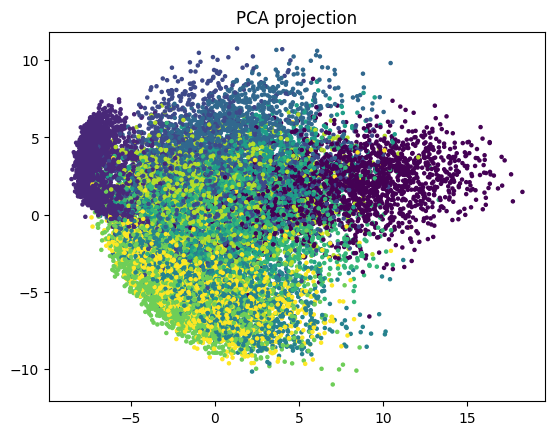

In [ ]:
reconstruction_mse, silhouette, pca_embeddings = eval_dim_reduc(
    PCA_model,
    flat_X_train,
    y_train[:sample_size],
    "PCA"
)
eval_metrics["PCA"] = {
    "reconstruction_mse": reconstruction_mse,
    "silhouette": silhouette
}

## KPCA

In [ ]:
KPCA_model = KernelPCA(n_components=2, fit_inverse_transform=True).fit(flat_X_train)

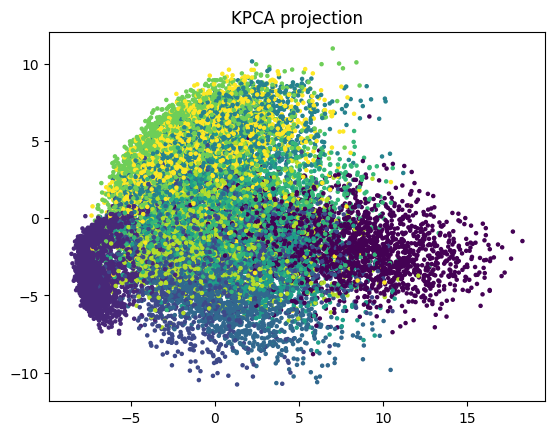

In [ ]:
reconstruction_mse, silhouette, kpca_embeddings = eval_dim_reduc(
    KPCA_model,
    flat_X_train,
    y_train[:sample_size],
    "KPCA"
)
eval_metrics["KPCA"] = {
    "reconstruction_mse": reconstruction_mse,
    "silhouette": silhouette
}

## UMAP

In [ ]:
UMAP_model = UMAP(n_components=2, random_state=42).fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


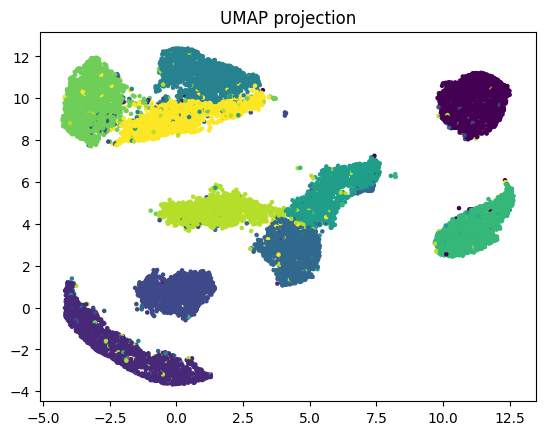

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
reconstruction_mse, silhouette, umap_embeddings = eval_dim_reduc(
    UMAP_model,
    flat_X_train,
    y_train[:sample_size],
    "UMAP"
)
eval_metrics["UMAP"] = {
    "reconstruction_mse": reconstruction_mse,
    "silhouette": silhouette
}

## T-SNE

In [ ]:
TSNE_model = TSNE(n_components=2, random_state=42)

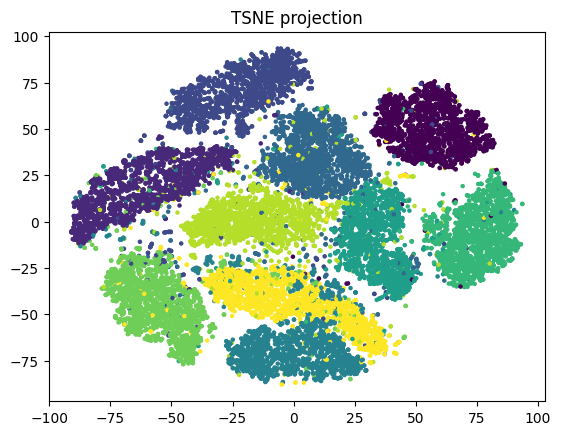

In [ ]:
reconstruction_mse, silhouette, tsne_embeddings = eval_dim_reduc(
    TSNE_model,
    flat_X_train,
    y_train[:sample_size],
    "TSNE"
)
eval_metrics["TSNE"] = {
    "reconstruction_mse": reconstruction_mse,
    "silhouette": silhouette
}

## PCA ==> UMAP

In [ ]:
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


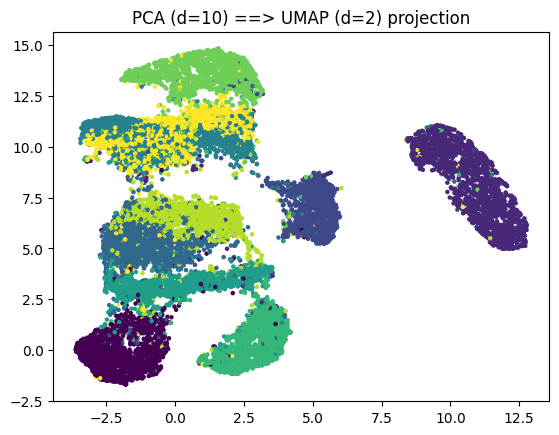

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


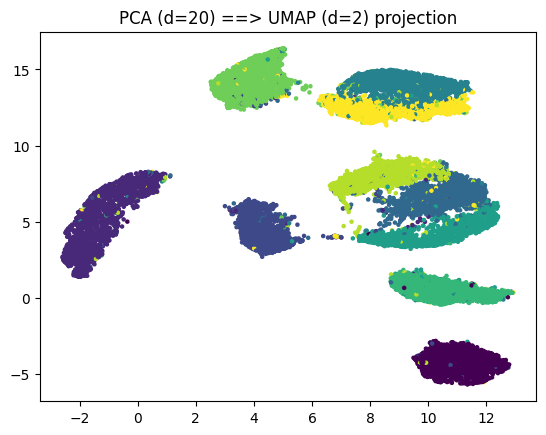

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


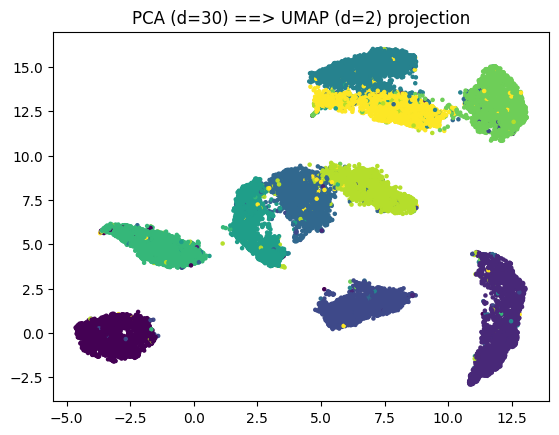

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


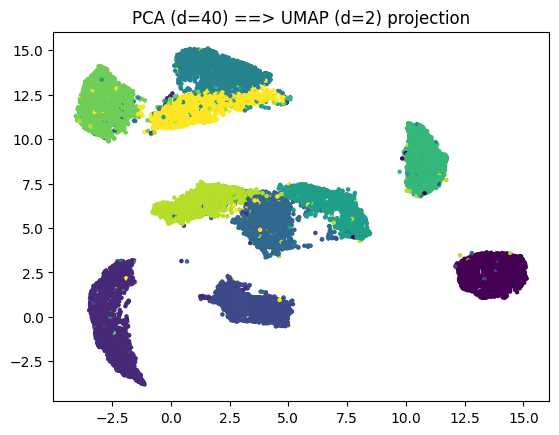

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


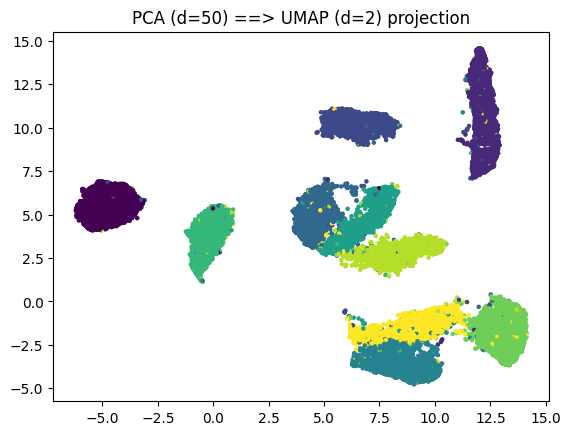

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
for i in range(1, 6):
  n_components = i*10
  dim_reduc_pipeline = Pipeline([
      ("PCA", PCA(n_components=n_components)),
      ("UMAP", UMAP(n_components=2, random_state=42))
  ])
  dim_reduc_pipeline = dim_reduc_pipeline.fit(flat_X_train)

  label = f"PCA (d={n_components}) ==> UMAP (d=2)"
  reconstruction_mse, silhouette, pca_umap_embeddings = eval_dim_reduc(
    dim_reduc_pipeline,
    flat_X_train,
    y_train[:sample_size],
    label
  )
  eval_metrics[label] = {
    "reconstruction_mse": reconstruction_mse,
    "silhouette": silhouette
  }

## [Random Projection?](https://scikit-learn.org/stable/modules/random_projection.html)

## Compare Dim Reduction Techniques

In [ ]:
evaluation_dict = {
    "method": list(),
    "reconstruction_mse": list(),
    "silhouette": list()
}

for method, metrics in eval_metrics.items():
  evaluation_dict["method"].append(method)
  evaluation_dict["reconstruction_mse"].append(metrics["reconstruction_mse"])
  evaluation_dict["silhouette"].append(metrics["silhouette"])

evaluation_df = pd.DataFrame(evaluation_dict)
evaluation_df.head()

,method,reconstruction_mse,silhouette
0,PCA,0.216654,0.010105
1,KPCA,0.878712,0.010106
2,UMAP,0.286782,0.471807
3,TSNE,NaN,0.359920
4,PCA (d=100) ==> UMAP (d=2),0.192082,0.505658


<ipython-input-71-3965d1019672>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


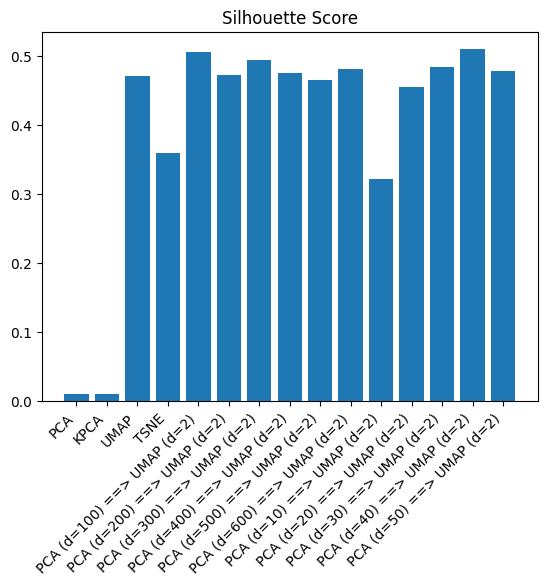

In [ ]:
plt.bar(x=evaluation_df["method"], height=evaluation_df["silhouette"])
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Silhouette Score")
plt.show()

<ipython-input-72-54963b6ce78c>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


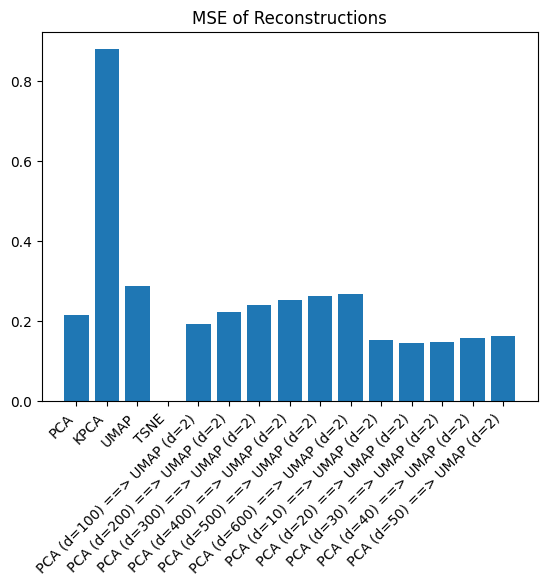

In [ ]:
plt.bar(x=evaluation_df["method"], height=evaluation_df["reconstruction_mse"])
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("MSE of Reconstructions")
plt.show()

# Final Model

## Dimensionality Reduction

In [ ]:
final_pipeline = Pipeline([
    ("PCA", PCA(n_components=40)),
    ("UMAP", UMAP(n_components=2, random_state=42))
])
label = "PCA (d=40) ==> UMAP (d=2)"
final_pipeline = final_pipeline.fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
reduced_mnist = final_pipeline.fit_transform(flat_X_train)
reduced_mnist_df = pd.DataFrame(reduced_mnist)

reduced_mnist_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
0,6.500267,6.396587
1,13.368768,2.101022
2,3.767967,13.605200
3,-1.881207,-2.746832
4,1.144917,11.958029


## Visualizations
Show samples from that latent space

[Code originally from here](https://umap-learn.readthedocs.io/en/latest/inverse_transform.html)

In [ ]:
final_pipeline

Pipeline(steps=[('PCA', PCA(n_components=40)),
                ('UMAP',
                 UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

In [ ]:
grid_size = 15

corners = np.array([
    [-3, -3],
    [-3, 15],
    [16, 2],
    [4.5, 15],
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, grid_size)
    for x in np.linspace(0, 1, grid_size)
])

In [ ]:
inv_transformed_points = final_pipeline.inverse_transform(test_pts)

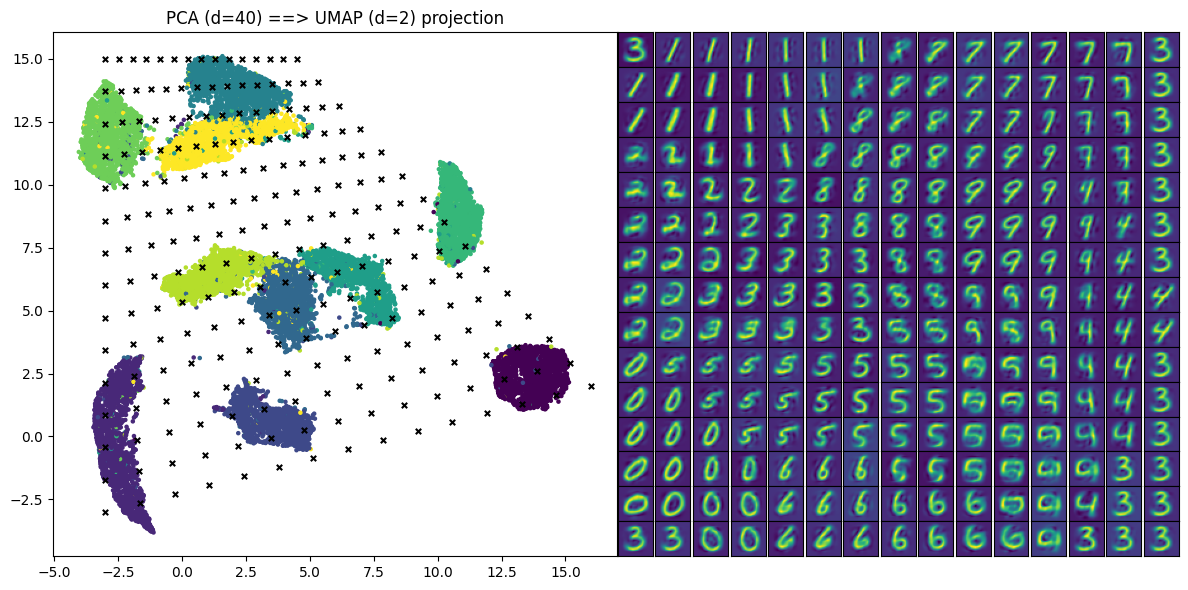

In [ ]:
# Set up the grid
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(grid_size, 2 * grid_size, fig)
# Set all padding in GridSpec to 0
gs.update(wspace=0, hspace=0)
scatter_ax = fig.add_subplot(gs[:, :grid_size])
digit_axes = np.zeros((grid_size, grid_size), dtype=object)

for i in range(grid_size):
    for j in range(grid_size):
        digit_axes[i, j] = fig.add_subplot(gs[i, grid_size + j])

# Plot projection onto the scatter axis (use scatter_ax, not plt)
scatter_ax.scatter(x=reduced_mnist_df[0],
                   y=reduced_mnist_df[1],
                   s=5,
                   c=y_train[:sample_size])
scatter_ax.set_title(f"{label} projection")

# Plot test points
scatter_ax.scatter(test_pts[:, 0],
                   test_pts[:, 1],
                   marker='x',
                   c='k',
                   s=15)

# Plot each of the generated digit images
for i in range(grid_size):
    for j in range(grid_size):
        ax = digit_axes[i, j]
        ax.imshow(inv_transformed_points[i * grid_size + j].reshape(28, 28))
        ax.set(xticks=[], yticks=[])

# Show everything at once
plt.tight_layout()
plt.show()